In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchsummary import summary
import torchvision
import matplotlib.pyplot as plt
import matplotlib
from sklearn import preprocessing
import itertools
import time
# from einops import rearrange, repeat
# from einops.layers.torch import Rearrange
%matplotlib inline

In [ ]:
train_data = torchvision.datasets.MNIST(
    root='./.mnist/',
    train=True,
    download=True
)
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False, download=True)

#change features to numpy
X_train = train_data.data.numpy()
X_test = test_data.data.numpy()

#change the labels to numpy
Y_train = train_data.targets.numpy()
Y_test = test_data.targets.numpy()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./.mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./.mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./.mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./.mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./.mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./.mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./.mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./.mnist/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [ ]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


# Prepare dataset

In [ ]:
X_train_scaled = X_train.reshape(X_train.shape[0], -1)
X_test_scaled = X_test.reshape(X_test.shape[0], -1)
X_train_scaled = preprocessing.minmax_scale(X_train_scaled)
X_test_scaled = preprocessing.minmax_scale(X_test_scaled)

## Scale data

In [ ]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(Y_train.shape)
print(Y_test.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


In [ ]:
X_train_tensor = torch.Tensor(X_train_scaled)
X_test_tensor = torch.Tensor(X_test_scaled)
Y_train_tensor = torch.LongTensor(Y_train)
Y_test_tensor = torch.LongTensor(Y_test)

## Pytoch dataset and dataloader

In [ ]:
class my_dataset(data.Dataset):
    def __init__(self, X, Y):
        self.data = X
        self.label = Y
        
    def __getitem__(self, index):
        return self.data[index], self.label[index]
    
    def __len__(self):
        return len(self.data)

In [ ]:
trainset = my_dataset(X_train_tensor, Y_train_tensor)
testset = my_dataset(X_test_tensor, Y_test_tensor)
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = data.DataLoader(testset, batch_size=20)

# 4. Deep Learning

In [ ]:
#define model
class NN(nn.Module):
    def __init__(self, input_size=784, hidden_size=100):
        super(NN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 10)
        )
        
    def forward(self, x):
      x = x.reshape(-1, 784)
      return self.fc(x)

In [ ]:
#define initialize function
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
def get_loss_acc(model, dataloader, criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    correct = 0
    total = 0
    total_loss = 0
    num_batches = 0
    for X_batch, Y_batch in dataloader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        total += len(Y_batch)
        num_batches += 1
        outputs = model(X_batch)
        y_pred = torch.argmax(outputs, dim=1)
        correct += torch.sum(y_pred == Y_batch).cpu().numpy()
        loss = criterion(outputs, Y_batch)
        total_loss += loss.item()
    acc = correct / total
    total_loss = total_loss / num_batches

    return total_loss, acc

In [ ]:
def train(model, epochs, trainloader, testloader, optimizer, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    training_record = {
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }
    model.train()
    best_test_loss = 0
    best_model_state = model.state_dict()
    for epoch in range(epochs):
        train_loss = 0
        num_batches = 0
        for X_batch, Y_batch in trainloader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            num_batches += 1
            #forward
            outputs = model(X_batch)

            loss = criterion(outputs, Y_batch)
            #backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        with torch.no_grad():
            #evaluate train
            train_loss, train_acc = get_loss_acc(model, trainloader, nn.CrossEntropyLoss())
            training_record["train_loss"].append(train_loss)
            training_record["train_acc"].append(train_acc)
            
            #evaluate test
            test_loss, test_acc = get_loss_acc(model, testloader, nn.CrossEntropyLoss())
            training_record["test_loss"].append(test_loss)
            training_record["test_acc"].append(test_acc)
            
        print("Epoch {}/{}  train_loss={} test_loss={} train_acc={} test_acc={}".format(
        epoch, epochs, training_record["train_loss"][-1], training_record["test_loss"][-1],
        training_record["train_acc"][-1], training_record["test_acc"][-1]))

        #save model state if it's the best
        if training_record["test_loss"][-1] < best_test_loss:
            best_model_state = model.state_dict()
        
    return model, training_record, best_model_state

## 3(a)

### Run 1

In [ ]:
EPOCHS = 150
model1 = NN()
model1.apply(initialize_weights)
optimizer = torch.optim.SGD(model1.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
model1, training_record1, best_state1 = train(model1, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/150  train_loss=0.23145560629920028 test_loss=0.22654686396801843 train_acc=0.9347833333333333 test_acc=0.9364
Epoch 1/150  train_loss=0.16944502023205574 test_loss=0.1717127078648191 train_acc=0.9512666666666667 test_acc=0.9503
Epoch 2/150  train_loss=0.12796732032897948 test_loss=0.13487263491330667 train_acc=0.9639 test_acc=0.9609
Epoch 3/150  train_loss=0.11286401276244347 test_loss=0.12434124264656567 train_acc=0.96785 test_acc=0.9618
Epoch 4/150  train_loss=0.09264461418736909 test_loss=0.10851449818501714 train_acc=0.9742333333333333 test_acc=0.9671
Epoch 5/150  train_loss=0.08298984980945394 test_loss=0.09964761627512053 train_acc=0.9764666666666667 test_acc=0.9688
Epoch 6/150  train_loss=0.06967839864747864 test_loss=0.08876332136726706 train_acc=0.9807333333333333 test_acc=0.9732
Epoch 7/150  train_loss=0.06268524650140786 test_loss=0.08642134383996017 train_acc=0.9831833333333333 test_acc=0.9724
Epoch 8/150  train_loss=0.057078614272475084 test_loss=0.084966121101315

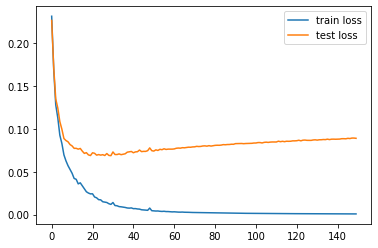

In [ ]:
plt.plot(range(EPOCHS), training_record1["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record1["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
model1 = NN()
model1.load_state_dict(best_state1)

<All keys matched successfully>

### Run 2

In [ ]:
EPOCHS = 150
model2 = NN()
model2.apply(initialize_weights)
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
model2, training_record2, best_state2 = train(model2, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/150  train_loss=0.23550439584674612 test_loss=0.22851528595387935 train_acc=0.9331833333333334 test_acc=0.9342
Epoch 1/150  train_loss=0.1675572509506046 test_loss=0.1687376241167076 train_acc=0.9522833333333334 test_acc=0.9511
Epoch 2/150  train_loss=0.12985757100127782 test_loss=0.13656000505387783 train_acc=0.9638 test_acc=0.9612
Epoch 3/150  train_loss=0.10915142359700539 test_loss=0.1170836588924285 train_acc=0.9694166666666667 test_acc=0.9659
Epoch 4/150  train_loss=0.09264655785063214 test_loss=0.1047967545966385 train_acc=0.9744333333333334 test_acc=0.97
Epoch 5/150  train_loss=0.08177577973758457 test_loss=0.09745423183578532 train_acc=0.9774 test_acc=0.9714
Epoch 6/150  train_loss=0.07115215199715547 test_loss=0.09100642460619565 train_acc=0.9805333333333334 test_acc=0.9742
Epoch 7/150  train_loss=0.06644021998197316 test_loss=0.08866979229613207 train_acc=0.9817 test_acc=0.9735
Epoch 8/150  train_loss=0.05668280925750653 test_loss=0.08141467432296486 train_acc=0.9848

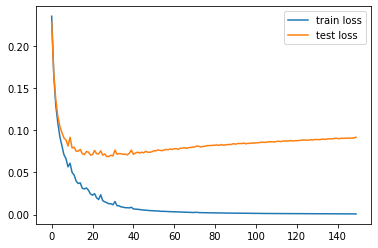

In [ ]:
plt.plot(range(EPOCHS), training_record2["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record2["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
model2 = NN()
model2.load_state_dict(best_state2)

<All keys matched successfully>

### Run 3

In [ ]:
EPOCHS = 150
model3 = NN()
model3.apply(initialize_weights)
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
model2, training_record3, best_state3 = train(model3, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/150  train_loss=0.23524483121725034 test_loss=0.23031261808983983 train_acc=0.9349 test_acc=0.9362
Epoch 1/150  train_loss=0.1663580174639281 test_loss=0.17248633008589967 train_acc=0.9538666666666666 test_acc=0.95
Epoch 2/150  train_loss=0.13622229511557676 test_loss=0.13942814750084653 train_acc=0.9619166666666666 test_acc=0.9575
Epoch 3/150  train_loss=0.11431698311469767 test_loss=0.124909879647661 train_acc=0.9683 test_acc=0.9629
Epoch 4/150  train_loss=0.1005238517820994 test_loss=0.11402642014541198 train_acc=0.9717333333333333 test_acc=0.9656
Epoch 5/150  train_loss=0.08178575399782517 test_loss=0.10102291186572984 train_acc=0.9777 test_acc=0.9694
Epoch 6/150  train_loss=0.07327362928571286 test_loss=0.09461510808416643 train_acc=0.9794166666666667 test_acc=0.9719
Epoch 7/150  train_loss=0.061896366173965434 test_loss=0.08479221622936893 train_acc=0.9833166666666666 test_acc=0.9739
Epoch 8/150  train_loss=0.05927517772046551 test_loss=0.08504691684915451 train_acc=0.984

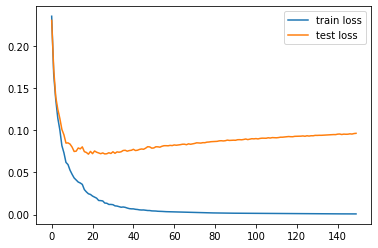

In [ ]:
plt.plot(range(EPOCHS), training_record3["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record3["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
model3 = NN()
model3.load_state_dict(best_state3)

<All keys matched successfully>

### Run 4

In [ ]:
EPOCHS = 150
model4 = NN()
model4.apply(initialize_weights)
optimizer = torch.optim.SGD(model4.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
model2, training_record4, best_state4 = train(model4, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/150  train_loss=0.22825378467882873 test_loss=0.2240673241596669 train_acc=0.9354166666666667 test_acc=0.9345
Epoch 1/150  train_loss=0.15584457866243842 test_loss=0.15884268807130866 train_acc=0.95525 test_acc=0.9549
Epoch 2/150  train_loss=0.12609653272775254 test_loss=0.1345700059721712 train_acc=0.9643166666666667 test_acc=0.9604
Epoch 3/150  train_loss=0.10809628644199577 test_loss=0.12266367797821294 train_acc=0.9688166666666667 test_acc=0.9635
Epoch 4/150  train_loss=0.08932974017652145 test_loss=0.1060521591345896 train_acc=0.97515 test_acc=0.9682
Epoch 5/150  train_loss=0.08904569431333177 test_loss=0.1117645680240821 train_acc=0.9738333333333333 test_acc=0.967
Epoch 6/150  train_loss=0.06836866600804332 test_loss=0.09282715042127529 train_acc=0.9807833333333333 test_acc=0.9714
Epoch 7/150  train_loss=0.06325519516734458 test_loss=0.08777553887537215 train_acc=0.9816833333333334 test_acc=0.9728
Epoch 8/150  train_loss=0.05581202348624704 test_loss=0.0862033765707165 tr

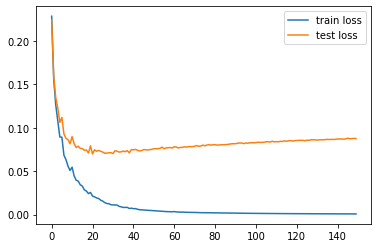

In [ ]:
plt.plot(range(EPOCHS), training_record4["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record4["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
model4 = NN()
model4.load_state_dict(best_state4)

<All keys matched successfully>

### Run 5

In [ ]:
EPOCHS = 150
model5 = NN()
model5.apply(initialize_weights)
optimizer = torch.optim.SGD(model5.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
model5, training_record5, best_state5 = train(model5, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/150  train_loss=0.24769342876573616 test_loss=0.24434030275978147 train_acc=0.92845 test_acc=0.9304
Epoch 1/150  train_loss=0.18011855886482608 test_loss=0.1796395236563403 train_acc=0.9471833333333334 test_acc=0.945
Epoch 2/150  train_loss=0.141204250327099 test_loss=0.15021574757434428 train_acc=0.9589666666666666 test_acc=0.9563
Epoch 3/150  train_loss=0.12027567336713073 test_loss=0.13309917828952894 train_acc=0.9651333333333333 test_acc=0.96
Epoch 4/150  train_loss=0.09681182066157365 test_loss=0.11564556246204302 train_acc=0.9726333333333333 test_acc=0.9649
Epoch 5/150  train_loss=0.08210076375910119 test_loss=0.09992011673684464 train_acc=0.9768166666666667 test_acc=0.9704
Epoch 6/150  train_loss=0.07472879397692775 test_loss=0.09540284925571177 train_acc=0.9784 test_acc=0.9724
Epoch 7/150  train_loss=0.0623972621246942 test_loss=0.08759086637358995 train_acc=0.9833833333333334 test_acc=0.9746
Epoch 8/150  train_loss=0.05707731060902161 test_loss=0.08510762964389869 trai

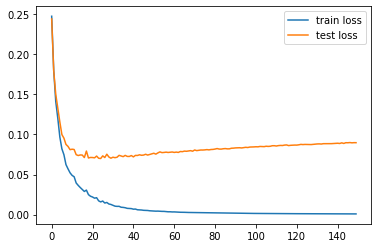

In [ ]:
plt.plot(range(EPOCHS), training_record5["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record5["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
model5 = NN()
model5.load_state_dict(best_state5)

<All keys matched successfully>

We can see that during the first few epochs, both train and test loss are decreasing. But after that, the train loss decreases while the test loss starts to increase. This is a sign of overfitting, which means the model can't be generalized to unseen samples.

## 3(b)

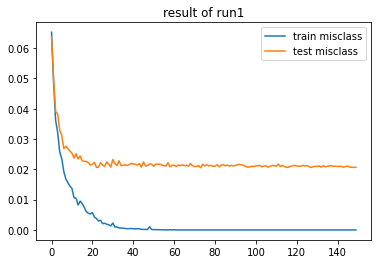

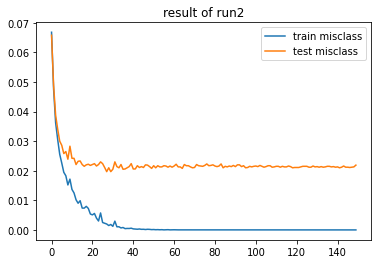

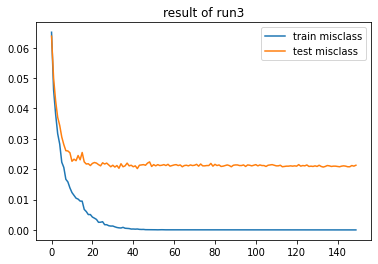

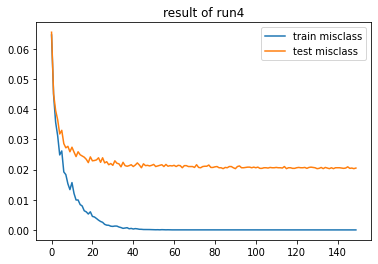

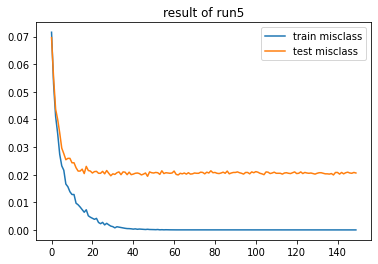

In [ ]:
for i, training_record in enumerate([training_record1, training_record2, training_record3, training_record4, training_record5]):
    plt.plot(range(EPOCHS), 1 - np.array(training_record["train_acc"]), label="train misclass")
    plt.plot(range(EPOCHS), 1 - np.array(training_record["test_acc"]), label="test misclass")
    title = "result of run{}".format(i + 1)
    plt.title(title)
    plt.legend()
    plt.show()

The train and test misclassification error decrease at the first few epochs. The difference is that the test error doesn't increase after overfitting, instead it fluctuates around the same level.

## 3(c)

In [ ]:
print(training_record1["test_acc"][-1])
print(training_record2["test_acc"][-1])
print(training_record3["test_acc"][-1])
print(training_record4["test_acc"][-1])
print(training_record5["test_acc"][-1])

0.9793
0.9781
0.9787
0.9795
0.9794


The best result is given by model4, which has the highest test accuracy 97.95%

In [ ]:
W = model4.fc[0].weight.data.reshape(10,10,-1)

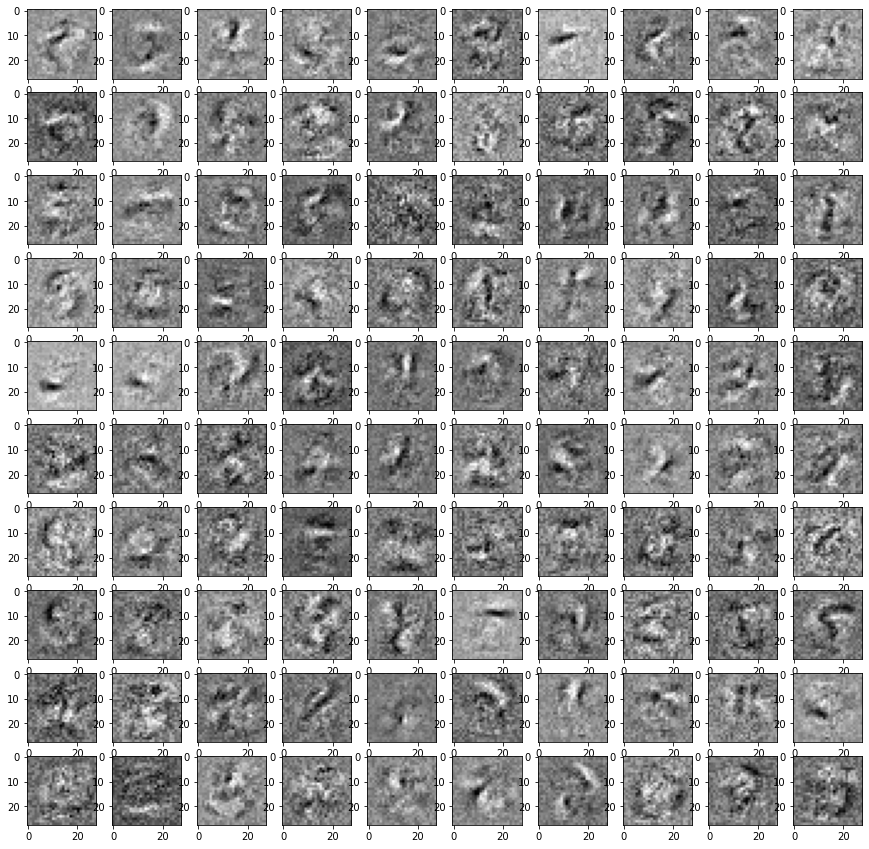

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(15,15))
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(W[i,j].reshape(28, 28), cmap="gray")

It seems that these features don't exhibit structures.

## 3(d)

In [ ]:
lrs = [0.01, 0.1, 0.2, 0.5]
moms = [0, 0.5, 0.9]
records = {}
for i, lr in enumerate(lrs):
    for j, mom in enumerate(moms):
        EPOCHS = 50
        model = NN()
        model.apply(initialize_weights)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mom)
        criterion = nn.CrossEntropyLoss()
        model, training_record, best_state = train(model, EPOCHS, trainloader, testloader, optimizer, criterion)
        records[(i,j)] = training_record

Epoch 0/50  train_loss=0.4781038119181641 test_loss=0.4584107413738966 train_acc=0.8755666666666667 test_acc=0.883
Epoch 1/50  train_loss=0.37611943148155963 test_loss=0.3605074106566608 train_acc=0.8956333333333333 test_acc=0.9026
Epoch 2/50  train_loss=0.33457026077009466 test_loss=0.3221483641937375 train_acc=0.90715 test_acc=0.9115
Epoch 3/50  train_loss=0.30838614710962087 test_loss=0.2989873021021485 train_acc=0.9138666666666667 test_acc=0.9177
Epoch 4/50  train_loss=0.28865187422140065 test_loss=0.2799667562339455 train_acc=0.9184166666666667 test_acc=0.9224
Epoch 5/50  train_loss=0.27347565489981984 test_loss=0.2666357660423964 train_acc=0.9229 test_acc=0.9262
Epoch 6/50  train_loss=0.25899081447644273 test_loss=0.2538435278637335 train_acc=0.928 test_acc=0.9301
Epoch 7/50  train_loss=0.24693124394204571 test_loss=0.24277673021890223 train_acc=0.93065 test_acc=0.9318
Epoch 8/50  train_loss=0.23744739365698433 test_loss=0.23465550057031215 train_acc=0.9329666666666667 test_acc=0

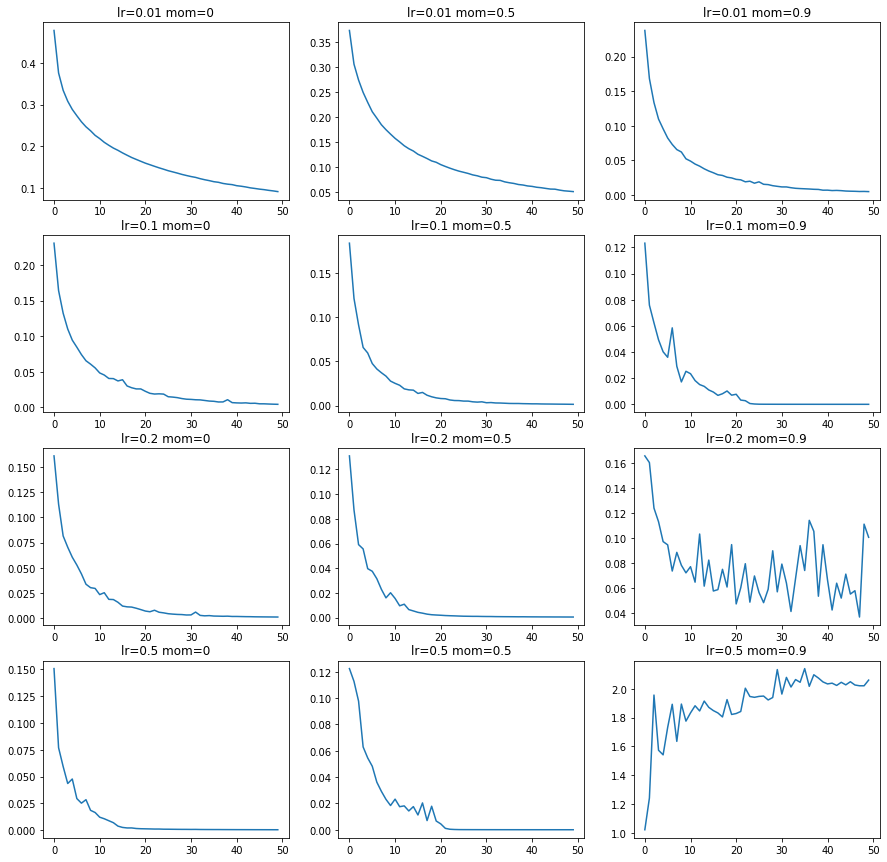

In [ ]:
fig, ax = plt.subplots(4,3,figsize=(15,15))
for i in range(len(lrs)):
    for j in range(len(moms)):
        title = "lr={} mom={}".format(lrs[i], moms[j])
        ax[i,j].plot(range(EPOCHS), records[(i,j)]["train_loss"], label="CELoss")
        ax[i,j].set_title(title)

The convergence is faster as learning rate increases when momentum is fixed.  
The convergence is faster as momentum increases when learning rate is fixed.  
But when learning rate is 0.5 and momentum is 0.9, it fails to converge.

## 4(a)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=(2,2))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=64, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(6 * 6 * 64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 6 * 64)
        x = F.relu(self.fc2(F.relu(self.fc1(x))))

        return x

In [ ]:
cnn = CNN().cuda()
summary(cnn, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             208
         MaxPool2d-2            [-1, 8, 14, 14]               0
            Conv2d-3           [-1, 64, 12, 12]           4,672
         MaxPool2d-4             [-1, 64, 6, 6]               0
            Linear-5                  [-1, 256]         590,080
            Linear-6                   [-1, 10]           2,570
Total params: 597,530
Trainable params: 597,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 2.28
Estimated Total Size (MB): 2.43
----------------------------------------------------------------


### Run 1

In [ ]:
EPOCHS = 150
CNN1 = CNN()
CNN1.apply(initialize_weights)
optimizer = torch.optim.SGD(CNN1.parameters(), lr=0.03)
criterion = nn.CrossEntropyLoss()
CNN1, training_record1, best_state1 = train(CNN1, EPOCHS, trainloader, testloader, optimizer, criterion)


Epoch 0/150  train_loss=0.3941178950133608 test_loss=0.37822738019190727 train_acc=0.8555333333333334 test_acc=0.8594
Epoch 1/150  train_loss=0.326018407126702 test_loss=0.3188020167455543 train_acc=0.8743666666666666 test_acc=0.8775
Epoch 2/150  train_loss=0.06483447651561501 test_loss=0.06508790300413966 train_acc=0.98 test_acc=0.9793
Epoch 3/150  train_loss=0.04931987583429229 test_loss=0.05098964488173806 train_acc=0.98485 test_acc=0.9835
Epoch 4/150  train_loss=0.039988131049140764 test_loss=0.04201057134580333 train_acc=0.9876833333333334 test_acc=0.9862
Epoch 5/150  train_loss=0.03652600010857979 test_loss=0.042827035921916834 train_acc=0.9888166666666667 test_acc=0.9852
Epoch 6/150  train_loss=0.026505252486516806 test_loss=0.03303349263792916 train_acc=0.99245 test_acc=0.9889
Epoch 7/150  train_loss=0.025939680803291648 test_loss=0.034013049339824644 train_acc=0.9921833333333333 test_acc=0.9895
Epoch 8/150  train_loss=0.02077596113509583 test_loss=0.031887151978600745 train_ac

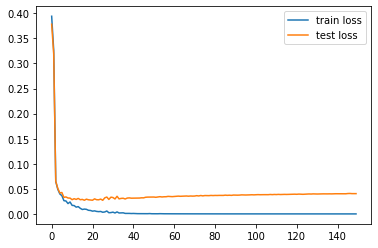

In [ ]:
plt.plot(range(EPOCHS), training_record1["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record1["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
CNN1.load_state_dict(best_state1)

<All keys matched successfully>

### Run 2

In [ ]:
EPOCHS = 150
CNN2 = CNN()
CNN2.apply(initialize_weights)
optimizer = torch.optim.SGD(CNN2.parameters(), lr=0.03)
criterion = nn.CrossEntropyLoss()
CNN2, training_record2, best_state2 = train(CNN2, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/150  train_loss=0.12698259522149494 test_loss=0.11294913103361615 train_acc=0.9609333333333333 test_acc=0.9628
Epoch 1/150  train_loss=0.07531289807083939 test_loss=0.06793069979245775 train_acc=0.9764 test_acc=0.9787
Epoch 2/150  train_loss=0.05887060245074062 test_loss=0.05707769326516427 train_acc=0.98175 test_acc=0.9818
Epoch 3/150  train_loss=0.047582957363411435 test_loss=0.042433713524325865 train_acc=0.9847166666666667 test_acc=0.9859
Epoch 4/150  train_loss=0.04930053418551856 test_loss=0.04994783545500832 train_acc=0.9845333333333334 test_acc=0.9841
Epoch 5/150  train_loss=0.04607381441864743 test_loss=0.04659827152326761 train_acc=0.9848166666666667 test_acc=0.9849
Epoch 6/150  train_loss=0.02679058833324265 test_loss=0.03300464060226841 train_acc=0.9917 test_acc=0.9888
Epoch 7/150  train_loss=0.03205234990298832 test_loss=0.039841183860720775 train_acc=0.98975 test_acc=0.987
Epoch 8/150  train_loss=0.03762523066498208 test_loss=0.05110448452149649 train_acc=0.987316

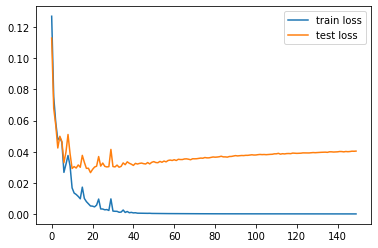

In [ ]:
plt.plot(range(EPOCHS), training_record2["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record2["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
CNN2.load_state_dict(best_state2)

<All keys matched successfully>

### Run 3

In [ ]:
EPOCHS = 150
CNN3 = CNN()
CNN3.apply(initialize_weights)
optimizer = torch.optim.SGD(CNN3.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
CNN3, training_record3, best_state3 = train(CNN3, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/150  train_loss=0.081252796697055 test_loss=0.07286181882402161 train_acc=0.9736166666666667 test_acc=0.975
Epoch 1/150  train_loss=0.03919358980364855 test_loss=0.038862555990548574 train_acc=0.9877166666666667 test_acc=0.9866
Epoch 2/150  train_loss=0.026485541298216494 test_loss=0.030282363575635827 train_acc=0.9919333333333333 test_acc=0.9895
Epoch 3/150  train_loss=0.02691740019923088 test_loss=0.03478193998825009 train_acc=0.9917166666666667 test_acc=0.9889
Epoch 4/150  train_loss=0.03174211353072644 test_loss=0.050642888648109875 train_acc=0.9893333333333333 test_acc=0.9851
Epoch 5/150  train_loss=0.014680494714504989 test_loss=0.029954122442311926 train_acc=0.9959333333333333 test_acc=0.9904
Epoch 6/150  train_loss=0.011375571033118223 test_loss=0.0290350117619148 train_acc=0.9966666666666667 test_acc=0.9909
Epoch 7/150  train_loss=0.012479105030001799 test_loss=0.03546312080652967 train_acc=0.9958833333333333 test_acc=0.9904
Epoch 8/150  train_loss=0.00842476950624189 

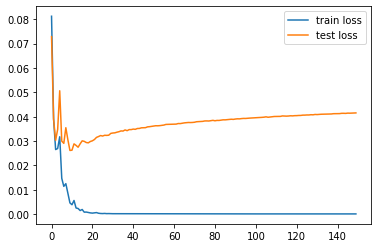

In [ ]:
plt.plot(range(EPOCHS), training_record3["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record3["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
CNN3.load_state_dict(best_state3)

<All keys matched successfully>

### Run 4

In [ ]:
EPOCHS = 150
CNN4 = CNN()
CNN4.apply(initialize_weights)
optimizer = torch.optim.SGD(CNN4.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
CNN4, training_record4, best_state4 = train(CNN4, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/150  train_loss=0.2835540114872174 test_loss=0.28318082810833584 train_acc=0.8879 test_acc=0.8883
Epoch 1/150  train_loss=0.06565069818476052 test_loss=0.06311017131002154 train_acc=0.9794166666666667 test_acc=0.9803
Epoch 2/150  train_loss=0.026523133978306718 test_loss=0.03144368433424097 train_acc=0.9917166666666667 test_acc=0.9901
Epoch 3/150  train_loss=0.02514502642910058 test_loss=0.031539944013546116 train_acc=0.9920666666666667 test_acc=0.9893
Epoch 4/150  train_loss=0.0144721758235725 test_loss=0.02352358676679887 train_acc=0.9957666666666667 test_acc=0.9921
Epoch 5/150  train_loss=0.013658081856584162 test_loss=0.025542365999794356 train_acc=0.9961833333333333 test_acc=0.9908
Epoch 6/150  train_loss=0.06495685157817113 test_loss=0.0784721535583285 train_acc=0.9791833333333333 test_acc=0.9758
Epoch 7/150  train_loss=0.008039003980237366 test_loss=0.02384322314832002 train_acc=0.9979666666666667 test_acc=0.9916
Epoch 8/150  train_loss=0.0055112722512954794 test_loss=0.

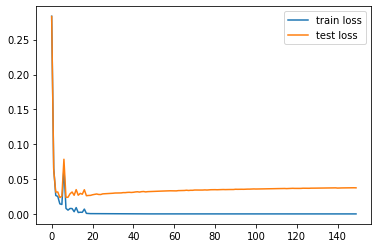

In [ ]:
plt.plot(range(EPOCHS), training_record4["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record4["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
CNN4.load_state_dict(best_state4)

<All keys matched successfully>

### Run 5

In [ ]:
EPOCHS = 150
CNN5 = CNN()
CNN5.apply(initialize_weights)
optimizer = torch.optim.SGD(CNN5.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
CNN5, training_record5, best_state5 = train(CNN5, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/150  train_loss=0.06815958748892276 test_loss=0.06403052899346949 train_acc=0.97895 test_acc=0.9794
Epoch 1/150  train_loss=0.2773754748819606 test_loss=0.2795568045624532 train_acc=0.91585 test_acc=0.9191
Epoch 2/150  train_loss=0.02909853085588196 test_loss=0.03439897994962303 train_acc=0.99085 test_acc=0.9887
Epoch 3/150  train_loss=0.028087865573844052 test_loss=0.03842214881228574 train_acc=0.9908833333333333 test_acc=0.9866
Epoch 4/150  train_loss=0.017291253741898476 test_loss=0.02740629940494955 train_acc=0.9944666666666667 test_acc=0.9915
Epoch 5/150  train_loss=0.013741720630607353 test_loss=0.02776769022949793 train_acc=0.9961666666666666 test_acc=0.9909
Epoch 6/150  train_loss=0.013315856927040983 test_loss=0.029875313418810834 train_acc=0.9957333333333334 test_acc=0.9903
Epoch 7/150  train_loss=0.010508890230280805 test_loss=0.028335000142952992 train_acc=0.9969333333333333 test_acc=0.9901
Epoch 8/150  train_loss=0.010934567904389124 test_loss=0.030093027442535232 

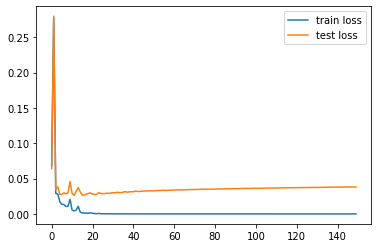

In [ ]:
plt.plot(range(EPOCHS), training_record5["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record5["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
CNN5.load_state_dict(best_state5)

<All keys matched successfully>

## 4(b)

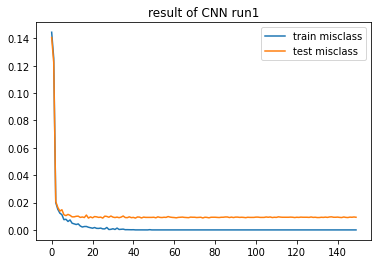

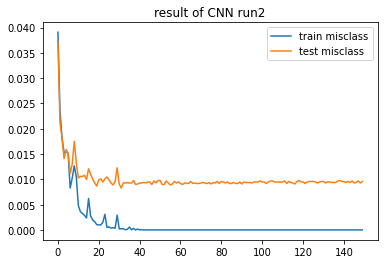

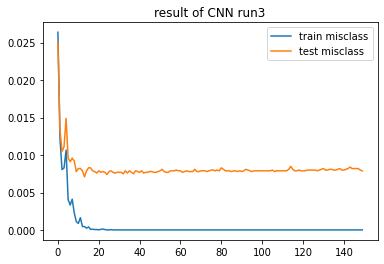

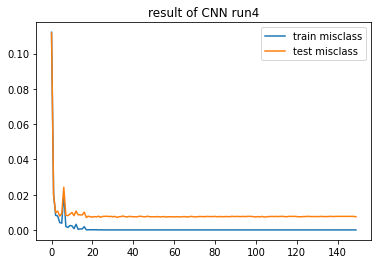

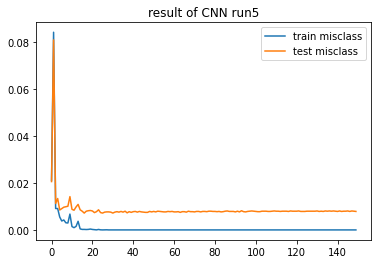

In [ ]:
for i, training_record in enumerate([training_record1, training_record2, training_record3, training_record4, training_record5]):
    plt.plot(range(EPOCHS), 1 - np.array(training_record["train_acc"]), label="train misclass")
    plt.plot(range(EPOCHS), 1 - np.array(training_record["test_acc"]), label="test misclass")
    title = "result of CNN run{}".format(i + 1)
    plt.title(title)
    plt.legend()
    plt.show()

The train and test misclassification error decrease at the first few epochs. The difference is that the test error doesn't increase after overfitting, instead it fluctuates around the same level.

## 4(c)

In [ ]:
print(training_record1["test_acc"][-1])
print(training_record2["test_acc"][-1])
print(training_record3["test_acc"][-1])
print(training_record4["test_acc"][-1])
print(training_record5["test_acc"][-1])

0.9907
0.9904
0.9921
0.9925
0.9921


The best model comes from the 4th run.

### Feature maps visualization(figures after the 1st convolution layer)

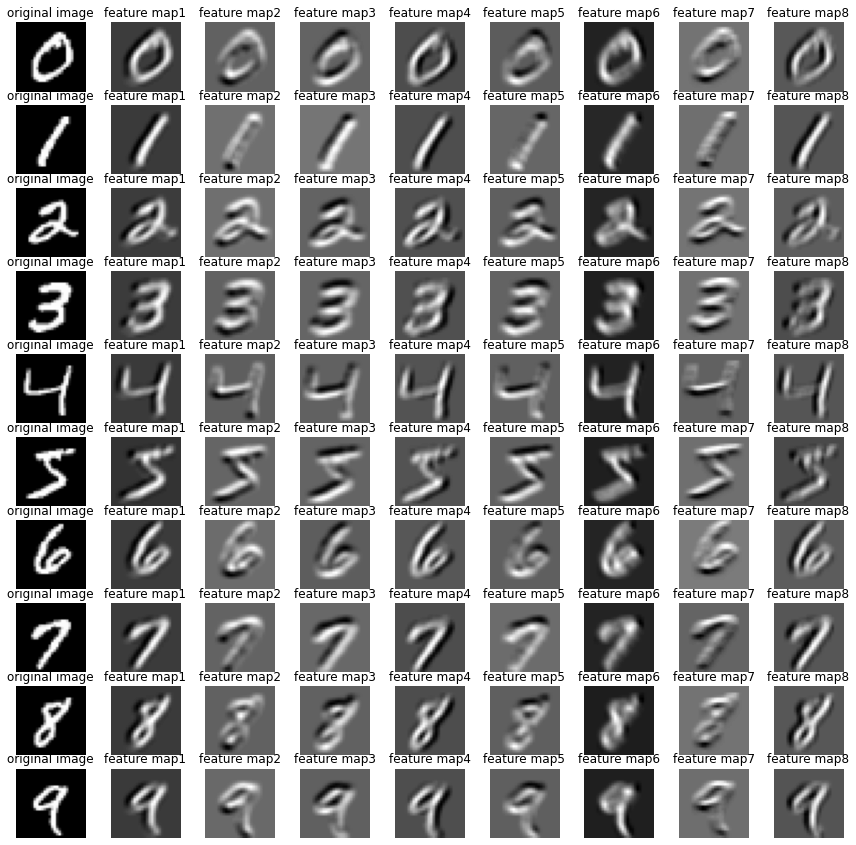

In [ ]:
best_model = CNN4.cpu()
fig, ax = plt.subplots(10, 9, figsize=(15,15))
for i in range(10):
    original_img = X_train_tensor[Y_train == i][0].cpu().detach().reshape(1,1,28,28)
    ax[i,0].imshow(original_img.squeeze().numpy(), cmap="gray")
    ax[i,0].set_title("original image")
    ax[i,0].axis("off")
    feature_maps = best_model.conv1(original_img).cpu().detach().numpy().squeeze()
    for j in range(8):
        feature_map = feature_maps[j]
        ax[i, j+1].imshow(feature_map, cmap="gray")
        ax[i, j+1].set_title("feature map{}".format(j+1))
        ax[i, j+1].axis("off")

### Kernels visualization(1st convolution layer)

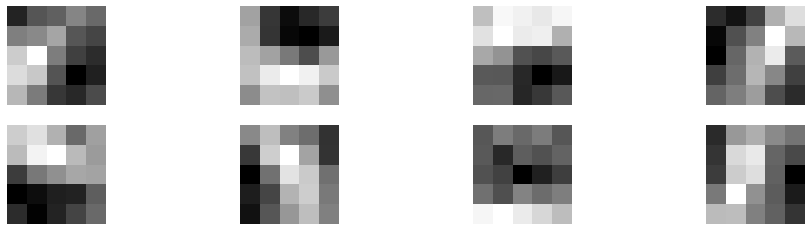

In [ ]:
params = list(best_model.parameters())[0]
plt.figure(figsize=(16,4))
for i in range(params.shape[0]):
    plt.subplot(2,4,i+1)
    x = params[i,0,:].detach().numpy()
    plt.imshow(x, cmap="gray")
    plt.axis("off")

## 4(d)

In [ ]:
lrs = [0.01, 0.1, 0.2, 0.5]
moms = [0, 0.5, 0.9]
records = {}
for i, lr in enumerate(lrs):
    for j, mom in enumerate(moms):
        EPOCHS = 50
        model = CNN()
        model.apply(initialize_weights)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mom)
        criterion = nn.CrossEntropyLoss()
        model, training_record, best_state = train(model, EPOCHS, trainloader, testloader, optimizer, criterion)
        records[(i,j)] = training_record

Epoch 0/50  train_loss=1.1411017160425816 test_loss=1.1182972832918168 train_acc=0.62235 test_acc=0.6329
Epoch 1/50  train_loss=0.8274035947218633 test_loss=0.8246907082796097 train_acc=0.7439 test_acc=0.7423
Epoch 2/50  train_loss=0.7989606458558711 test_loss=0.7938428390324116 train_acc=0.7680166666666667 test_acc=0.7657
Epoch 3/50  train_loss=0.7688991706063752 test_loss=0.7667922419309616 train_acc=0.7754166666666666 test_acc=0.7744
Epoch 4/50  train_loss=0.7857783664581872 test_loss=0.7846003420650959 train_acc=0.76655 test_acc=0.7663
Epoch 5/50  train_loss=0.7429643397900596 test_loss=0.7434551677405834 train_acc=0.7824666666666666 test_acc=0.7819
Epoch 6/50  train_loss=0.3204241797272394 test_loss=0.32381251129321753 train_acc=0.8793666666666666 test_acc=0.8769
Epoch 7/50  train_loss=0.2958702519178581 test_loss=0.2945670270747505 train_acc=0.88525 test_acc=0.8841
Epoch 8/50  train_loss=0.2807265450196988 test_loss=0.28055495882127435 train_acc=0.8885166666666666 test_acc=0.8863

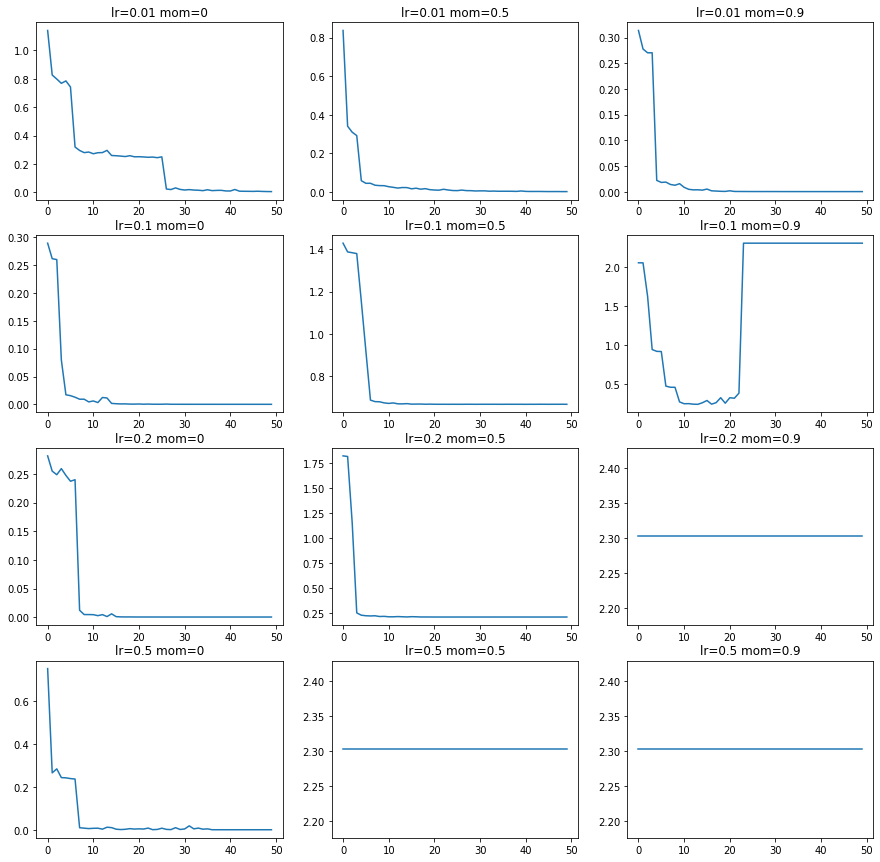

In [ ]:
fig, ax = plt.subplots(4,3,figsize=(15,15))
for i in range(len(lrs)):
  for j in range(len(moms)):
    title = "lr={} mom={}".format(lrs[i], moms[j])
    ax[i,j].plot(range(EPOCHS), records[(i,j)]["train_loss"], label="CELoss")
    ax[i,j].set_title(title)

We can see that, when momentum is 0, it converges for all choices of learning rate.  
For momentum 0.5 and 0.9, it fails to converge when learning rate is high.

## 5(a)

In [ ]:
class CNNplus(nn.Module):
    def __init__(self):
        super(CNNplus, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(0.1, inplace=True)
        self.fc1 = nn.Linear(6 * 6 * 64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # x = self.pool1(F.relu(self.conv1(x)))
        # x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 6 * 64)
        x = F.relu(self.fc2(F.relu(self.fc1(x))))

        return x

class CNNplus(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNplus, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*64, num_classes)
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
cnnplus = CNNplus().cuda()
summary(cnnplus, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          25,664
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Linear-9                   [-1, 10]          31,370
Total params: 57,610
Trainable params: 57,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.62
Params size (MB): 0.22
Estimated Total Size (MB): 0.84
---------------------------------------------

### Run 1

In [ ]:
EPOCHS = 100
cnnplus1 = CNNplus()
cnnplus1.apply(initialize_weights)
optimizer = torch.optim.SGD(cnnplus1.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
cnnplus1, training_record1, best_state1 = train(cnnplus1, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/100  train_loss=0.13721688987730918 test_loss=0.1255499667325057 train_acc=0.96335 test_acc=0.9664
Epoch 1/100  train_loss=0.09104170571210415 test_loss=0.08485442168312148 train_acc=0.97605 test_acc=0.9759
Epoch 2/100  train_loss=0.07488156610460424 test_loss=0.07063419927936047 train_acc=0.9800166666666666 test_acc=0.9791
Epoch 3/100  train_loss=0.06356971519095685 test_loss=0.06078280475118663 train_acc=0.9826166666666667 test_acc=0.9822
Epoch 4/100  train_loss=0.05603959630610846 test_loss=0.05570664575067349 train_acc=0.9844333333333334 test_acc=0.983
Epoch 5/100  train_loss=0.05047907755086655 test_loss=0.04914776450267527 train_acc=0.9862 test_acc=0.9855
Epoch 6/100  train_loss=0.04572923213113417 test_loss=0.04569383067305898 train_acc=0.9873 test_acc=0.9859
Epoch 7/100  train_loss=0.042940845175870636 test_loss=0.04506996289163362 train_acc=0.9882833333333333 test_acc=0.9859
Epoch 8/100  train_loss=0.03977328837131347 test_loss=0.04348050112853525 train_acc=0.989216666

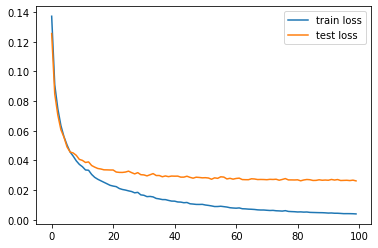

In [ ]:
plt.plot(range(EPOCHS), training_record1["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record1["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
cnnplus1.load_state_dict(best_state1)

<All keys matched successfully>

### Run 2

In [ ]:
EPOCHS = 100
cnnplus2 = CNNplus()
cnnplus2.apply(initialize_weights)
optimizer = torch.optim.SGD(cnnplus2.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
cnnplus2, training_record2, best_state2 = train(cnnplus2, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/100  train_loss=0.1359968757443527 test_loss=0.12668210134096444 train_acc=0.9645666666666667 test_acc=0.9648
Epoch 1/100  train_loss=0.09280075130265342 test_loss=0.08789713654760271 train_acc=0.9748 test_acc=0.9726
Epoch 2/100  train_loss=0.07531675701238104 test_loss=0.07138021346041933 train_acc=0.9793833333333334 test_acc=0.9786
Epoch 3/100  train_loss=0.06641282673790129 test_loss=0.0634786964468658 train_acc=0.9813166666666666 test_acc=0.9803
Epoch 4/100  train_loss=0.05590093265652958 test_loss=0.05654439315001946 train_acc=0.98485 test_acc=0.9823
Epoch 5/100  train_loss=0.05094919149785725 test_loss=0.05157535874017049 train_acc=0.9857833333333333 test_acc=0.9831
Epoch 6/100  train_loss=0.046218639845326384 test_loss=0.047532485904637725 train_acc=0.98755 test_acc=0.9841
Epoch 7/100  train_loss=0.04270945011582503 test_loss=0.046406750749098134 train_acc=0.9887166666666667 test_acc=0.9842
Epoch 8/100  train_loss=0.04080190637440824 test_loss=0.04413693859043997 train_a

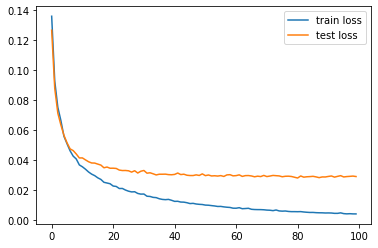

In [ ]:
plt.plot(range(EPOCHS), training_record2["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record2["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
cnnplus2.load_state_dict(best_state2)

<All keys matched successfully>

### Run 3

In [ ]:
EPOCHS = 100
cnnplus3 = CNNplus()
cnnplus3.apply(initialize_weights)
optimizer = torch.optim.SGD(cnnplus3.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
cnnplus3, training_record3, best_state3 = train(cnnplus3, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/100  train_loss=0.137418263917491 test_loss=0.12755860297055915 train_acc=0.9635666666666667 test_acc=0.9643
Epoch 1/100  train_loss=0.09519360741890316 test_loss=0.08929876394337043 train_acc=0.9741666666666666 test_acc=0.9733
Epoch 2/100  train_loss=0.07751602678299585 test_loss=0.07308272480661981 train_acc=0.9794666666666667 test_acc=0.9791
Epoch 3/100  train_loss=0.06689669761502905 test_loss=0.06654020175349433 train_acc=0.9820833333333333 test_acc=0.9803
Epoch 4/100  train_loss=0.058864669348579896 test_loss=0.05844535111973528 train_acc=0.9842166666666666 test_acc=0.9828
Epoch 5/100  train_loss=0.053218751834002515 test_loss=0.05336107589281164 train_acc=0.9861 test_acc=0.9837
Epoch 6/100  train_loss=0.049543427497541696 test_loss=0.05144102026388282 train_acc=0.9860666666666666 test_acc=0.9846
Epoch 7/100  train_loss=0.048128795383353115 test_loss=0.04827921586832963 train_acc=0.98685 test_acc=0.985
Epoch 8/100  train_loss=0.04229727736674249 test_loss=0.04600666817522

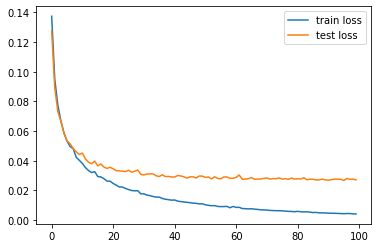

In [ ]:
plt.plot(range(EPOCHS), training_record3["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record3["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
cnnplus3.load_state_dict(best_state3)

<All keys matched successfully>

### Run 4

In [ ]:
EPOCHS = 100
cnnplus4 = CNNplus()
cnnplus4.apply(initialize_weights)
optimizer = torch.optim.SGD(cnnplus4.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
cnnplus4, training_record4, best_state4 = train(cnnplus4, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/100  train_loss=0.1331576123150554 test_loss=0.12691750465240328 train_acc=0.9659166666666666 test_acc=0.9663
Epoch 1/100  train_loss=0.08913714007865678 test_loss=0.08430726970965043 train_acc=0.9765833333333334 test_acc=0.976
Epoch 2/100  train_loss=0.07194362820854891 test_loss=0.07054406565288082 train_acc=0.9809 test_acc=0.9793
Epoch 3/100  train_loss=0.06170055470757012 test_loss=0.06130245617940091 train_acc=0.9835333333333334 test_acc=0.9822
Epoch 4/100  train_loss=0.05365859495817439 test_loss=0.055141564074205236 train_acc=0.9856833333333334 test_acc=0.9837
Epoch 5/100  train_loss=0.04923011214662987 test_loss=0.05019150350883137 train_acc=0.9863666666666666 test_acc=0.9852
Epoch 6/100  train_loss=0.04615682032136028 test_loss=0.0492329195656348 train_acc=0.9874 test_acc=0.9854
Epoch 7/100  train_loss=0.04199643763127739 test_loss=0.04494908522017067 train_acc=0.98875 test_acc=0.9871
Epoch 8/100  train_loss=0.03894259157190437 test_loss=0.044301259390311314 train_acc=

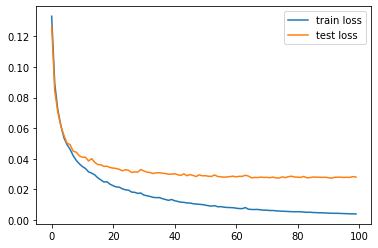

In [ ]:
plt.plot(range(EPOCHS), training_record4["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record4["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
cnnplus4.load_state_dict(best_state4)

<All keys matched successfully>

### Run 5

In [ ]:
EPOCHS = 100
cnnplus5 = CNNplus()
cnnplus5.apply(initialize_weights)
optimizer = torch.optim.SGD(cnnplus5.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
cnnplus5, training_record5, best_state5 = train(cnnplus5, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/100  train_loss=0.13179892027921386 test_loss=0.12418343965802342 train_acc=0.9652833333333334 test_acc=0.9677
Epoch 1/100  train_loss=0.09253921711853128 test_loss=0.08815065410314128 train_acc=0.9753333333333334 test_acc=0.9745
Epoch 2/100  train_loss=0.07669663829391381 test_loss=0.07202502860338428 train_acc=0.9787333333333333 test_acc=0.9789
Epoch 3/100  train_loss=0.06246871130862661 test_loss=0.06028361442813184 train_acc=0.9828333333333333 test_acc=0.9819
Epoch 4/100  train_loss=0.05549388807932181 test_loss=0.05498816273664124 train_acc=0.9846833333333334 test_acc=0.9825
Epoch 5/100  train_loss=0.050670752398121646 test_loss=0.052731117658899165 train_acc=0.9859333333333333 test_acc=0.9831
Epoch 6/100  train_loss=0.045972232804643604 test_loss=0.04731557271344354 train_acc=0.9874166666666667 test_acc=0.9852
Epoch 7/100  train_loss=0.043376721645534626 test_loss=0.04571795583429048 train_acc=0.98825 test_acc=0.9844
Epoch 8/100  train_loss=0.042102434261858876 test_loss=

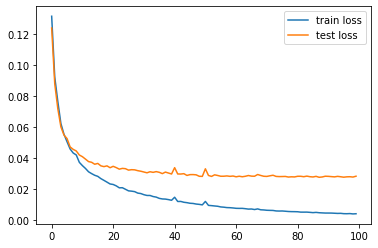

In [ ]:
plt.plot(range(EPOCHS), training_record5["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record5["test_loss"], label="test loss")
plt.legend()
plt.show()

In [ ]:
cnnplus5.load_state_dict(best_state5)

<All keys matched successfully>

## 5(b)

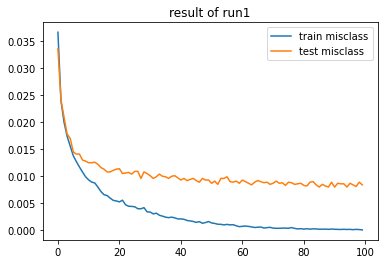

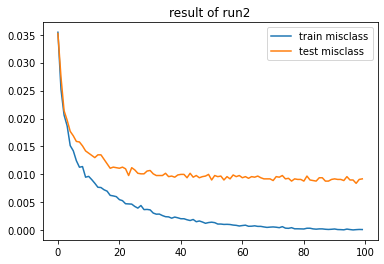

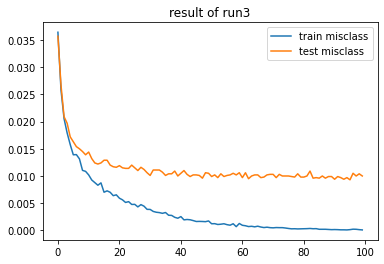

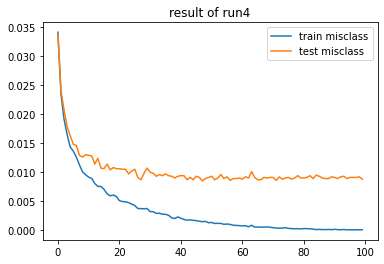

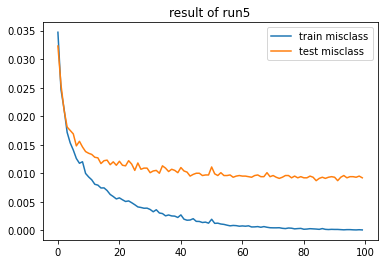

In [ ]:
for i, training_record in enumerate([training_record1, training_record2, training_record3, training_record4, training_record5]):
  plt.plot(range(EPOCHS), 1 - np.array(training_record["train_acc"]), label="train misclass")
  plt.plot(range(EPOCHS), 1 - np.array(training_record["test_acc"]), label="test misclass")
  title = "result of run{}".format(i + 1)
  plt.title(title)
  plt.legend()
  plt.show()

## 5(c)

In [ ]:
print(training_record1["test_acc"][-1])
print(training_record2["test_acc"][-1])
print(training_record3["test_acc"][-1])
print(training_record4["test_acc"][-1])
print(training_record5["test_acc"][-1])

0.9916
0.9908
0.99
0.9912
0.9908


The best model is given by the first run

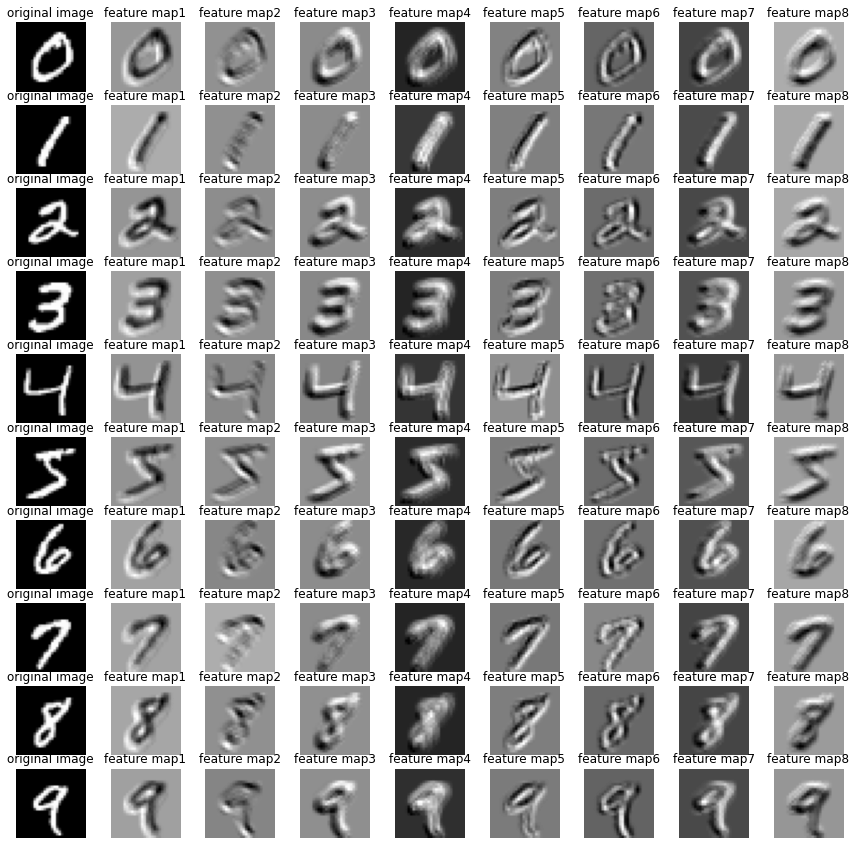

In [ ]:
best_model = cnnplus1.cpu()
fig, ax = plt.subplots(10, 9, figsize=(15,15))
for i in range(10):
    original_img = X_train_tensor[Y_train == i][0].cpu().detach().reshape(1,1,28,28)
    ax[i,0].imshow(original_img.squeeze().numpy(), cmap="gray")
    ax[i,0].set_title("original image")
    ax[i,0].axis("off")
    feature_maps = best_model.layer1[0](original_img).cpu().detach().numpy().squeeze()
    for j in range(8):
        feature_map = feature_maps[j]
        ax[i, j+1].imshow(feature_map, cmap="gray")
        ax[i, j+1].set_title("feature map{}".format(j+1))
        ax[i, j+1].axis("off")

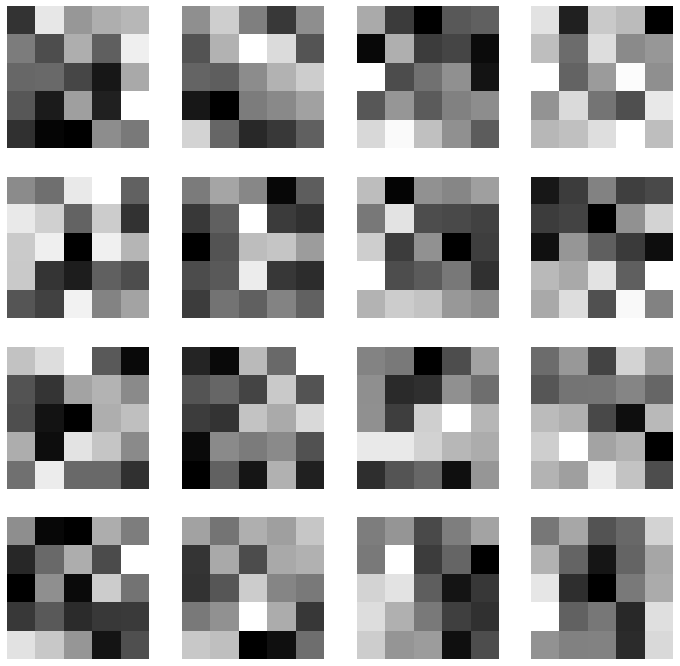

In [ ]:
params = list(best_model.parameters())[0]
plt.figure(figsize=(12,12))
for i in range(params.shape[0]):
    plt.subplot(4,4,i+1)
    x = params[i,0,:].detach().numpy()
    plt.imshow(x, cmap="gray")
    plt.axis("off")

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale == 1:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes * block.expansion:
        downsample = nn.Sequential(
          nn.Conv2d(self.inplanes, planes * block.expansion,
               kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(planes * block.expansion)
        )
    
    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample))
    self.inplanes = planes * block.expansion
    for i in range(1, blocks):
        layers.append(block(self.inplanes, planes))

    return nn.Sequential(*layers)
  
    def forward(self, x):
        x = x.reshape(-1, 1, 28, 28)  #x: B 1 28 28
        x = self.conv1(x)  # B 64 28 28
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # B 64 14 14

        x = self.layer1(x)  # B 64 7 7
        x = self.layer2(x)  # B 128 4 4
        x = self.layer3(x)  # B 256 2 2
        x = self.layer4(x)  # B 512 1 1

        x = x.reshape(x.size(0), -1)  # B 512
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)

        return logits

In [ ]:
EPOCHS = 40
resnet1 = ResNet(block=BasicBlock, layers=[2,2,2,2], num_classes=10, grayscale=True)
optimizer = torch.optim.Adam(resnet1.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
resnet1, training_record1, best_state1 = train(resnet1, EPOCHS, trainloader, testloader, optimizer, criterion)

Epoch 0/40  train_loss=0.0611024123924558 test_loss=0.08540616664267145 train_acc=0.98235 test_acc=0.9769
Epoch 1/40  train_loss=0.055174726273378986 test_loss=0.07886605661024805 train_acc=0.9829833333333333 test_acc=0.9767
Epoch 2/40  train_loss=0.05781477743482737 test_loss=0.07567126244923565 train_acc=0.9834 test_acc=0.9781
Epoch 3/40  train_loss=0.03557242090944876 test_loss=0.07123761327509419 train_acc=0.9898166666666667 test_acc=0.9821
Epoch 4/40  train_loss=0.028895106705487457 test_loss=0.14932594255623552 train_acc=0.9915 test_acc=0.98
Epoch 5/40  train_loss=0.027404103809143546 test_loss=0.05940343223229138 train_acc=0.9917333333333334 test_acc=0.9846
Epoch 6/40  train_loss=0.01847997303574725 test_loss=0.05165360572684949 train_acc=0.9943 test_acc=0.9869
Epoch 7/40  train_loss=0.01924778183800916 test_loss=0.05303257715803557 train_acc=0.9941333333333333 test_acc=0.9874
Epoch 8/40  train_loss=0.019789715600162766 test_loss=0.050443760383343035 train_acc=0.9939666666666667

In [ ]:
class CNNplus(nn.Module):
    def __init__(self):
        super(CNNplus, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128,
            kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.tns1 = nn.Conv2d(in_channels=128, out_channels=4,
            kernel_size=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16,
            kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=16)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32,
            kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=32)

        self.pool2 = nn.MaxPool2d(2, 2)
        self.tns2 = nn.Conv2d(in_channels=32, out_channels=16,
            kernel_size=1, padding=1)

        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=16)
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=32,
            kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(num_features=32)
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=10,
            kernel_size=1, padding=1)
        self.gpool = nn.AvgPool2d(kernel_size=7)
        self.drop = nn.Dropout2d(0.1)
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.tns1(self.drop(self.bn1(F.relu(self.conv1(x)))))
        x = self.drop(self.bn2(F.relu(self.conv2(x))))
        x = self.pool1(x)
        x = self.drop(self.bn3(F.relu(self.conv3(x))))
        x = self.drop(self.bn4(F.relu(self.conv4(x))))
        x = self.tns2(self.pool2(x))
        x = self.drop(self.bn5(F.relu(self.conv5(x))))
        x = self.drop(self.bn6(F.relu(self.conv6(x))))
        x = self.conv7(x)
        x = self.gpool(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

In [ ]:
EPOCHS = 100
cnnplus1 = CNNplus()
optimizer = torch.optim.Adam(cnnplus1.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
cnnplus1, training_record1, best_state1 = train(cnnplus1, EPOCHS, trainloader, testloader, optimizer, criterion)

# More about Deep Learning

## 6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.txt', header=None).to_numpy()
Y_train = X_train[:,-1]
X_train = X_train[:,:-1]
X_val = pd.read_csv('/content/drive/My Drive/Colab Notebooks/val.txt', header=None).to_numpy()
Y_val = X_val[:,-1]
X_val = X_val[:,:-1]
X_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.txt', header=None).to_numpy()
Y_test = X_test[:,-1]
X_test = X_test[:,:-1]
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(20000, 1568)
(5000, 1568)
(5000, 1568)


In [ ]:
def show_2_img(x):
    img = x.reshape(28, 56)
    plt.imshow(img, cmap="gray")
    plt.show()

Label is 5.0


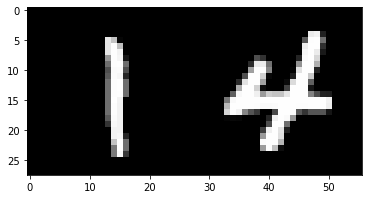

In [ ]:
print("Label is {}".format(Y_train[0]))
show_2_img(X_train[0])

Label is 10.0


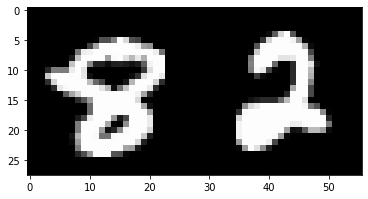

In [ ]:
print("Label is {}".format(Y_test[4]))
show_2_img(X_test[4])

In [ ]:
X_train_scaled = X_train.reshape(X_train.shape[0], -1)
X_val_scaled = X_val.reshape(X_val.shape[0], -1)
X_test_scaled = X_test.reshape(X_test.shape[0], -1)
X_train_scaled = preprocessing.minmax_scale(X_train_scaled)
X_val_scaled = preprocessing.minmax_scale(X_val_scaled)
X_test_scaled = preprocessing.minmax_scale(X_test_scaled)

X_train_tensor = torch.Tensor(X_train_scaled.reshape(-1, 28, 56))
X_val_tensor = torch.Tensor(X_val_scaled.reshape(-1, 28, 56))
X_test_tensor = torch.Tensor(X_test_scaled.reshape(-1, 28, 56))
Y_train_tensor = torch.LongTensor(Y_train)
Y_val_tensor = torch.LongTensor(Y_val)
Y_test_tensor = torch.LongTensor(Y_test)

trainset = my_dataset(X_train_tensor, Y_train_tensor)
valset = my_dataset(X_val_tensor, Y_val_tensor)
testset = my_dataset(X_test_tensor, Y_test_tensor)
train_loader = data.DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = data.DataLoader(valset, batch_size=20)
test_loader = data.DataLoader(testset, batch_size=20)

## 7

In [ ]:
def train7(model, epochs, trainloader, testloader, optimizer, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    training_record = {
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }
    model.train()
    best_test_acc = 0
    best_model_state = model.state_dict()
    for epoch in range(epochs):
        train_loss = 0
        num_batches = 0
        for X_batch, Y_batch in trainloader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            num_batches += 1
            #forward
            outputs = model(X_batch)

            loss = criterion(outputs, Y_batch)
            #backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        with torch.no_grad():
            #evaluate train
            train_loss, train_acc = get_loss_acc(model, trainloader, nn.CrossEntropyLoss())
            training_record["train_loss"].append(train_loss)
            training_record["train_acc"].append(train_acc)
            
            #evaluate test
            test_loss, test_acc = get_loss_acc(model, testloader, nn.CrossEntropyLoss())
            training_record["test_loss"].append(test_loss)
            training_record["test_acc"].append(test_acc)
            
        print("Epoch {}/{}  train_loss={} val_loss={} train_acc={} val_acc={}".format(
        epoch, epochs, training_record["train_loss"][-1], training_record["test_loss"][-1],
        training_record["train_acc"][-1], training_record["test_acc"][-1]))

        #save model state if it's the best
        if training_record["test_acc"][-1] < best_test_acc:
            best_model_state = model.state_dict()
        
    return model, training_record, best_model_state

### Model 1

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 2, 200)
        self.fc2 = nn.Linear(200, 19)

    def forward(self, x):
        x = x.view(-1, 28 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
#train 2 layer NN
EPOCHS = 100
nn1 = NN()
optimizer = torch.optim.SGD(nn1.parameters(), lr=0.1, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
nn1, training_record1, best_state1 = train7(nn1, epochs, train_loader, val_loader, optimizer, criterion)

Epoch 0/100  train_loss=2.291752815246582 val_loss=2.330982689857483 train_acc=0.2395 val_acc=0.214
Epoch 1/100  train_loss=1.8628746754826067 val_loss=1.940201651096344 train_acc=0.3857 val_acc=0.3488
Epoch 2/100  train_loss=1.5375233713430339 val_loss=1.6498502926826477 train_acc=0.5042 val_acc=0.4628
Epoch 3/100  train_loss=1.2271528036449664 val_loss=1.3795407929420471 train_acc=0.6266 val_acc=0.5616
Epoch 4/100  train_loss=1.0744756509701665 val_loss=1.2700491404533387 train_acc=0.662 val_acc=0.5884
Epoch 5/100  train_loss=0.9442867244394443 val_loss=1.160149831533432 train_acc=0.7227 val_acc=0.6348
Epoch 6/100  train_loss=0.8354073393459137 val_loss=1.0881786568164826 train_acc=0.75725 val_acc=0.6604
Epoch 7/100  train_loss=0.7428608206323922 val_loss=1.024773632645607 train_acc=0.79265 val_acc=0.681
Epoch 8/100  train_loss=0.7253111022920273 val_loss=1.0434485076665878 train_acc=0.7866 val_acc=0.6714
Epoch 9/100  train_loss=0.7011116641207625 val_loss=1.053681011915207 train_acc

In [ ]:
nn1.load_state_dict(best_state1)

<All keys matched successfully>

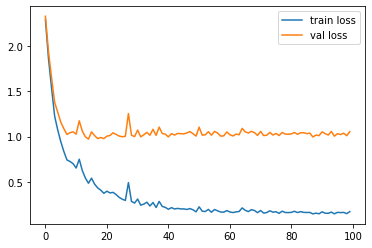

In [ ]:
plt.plot(range(EPOCHS), training_record1["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record1["test_loss"], label="val loss")
plt.legend()
plt.show()

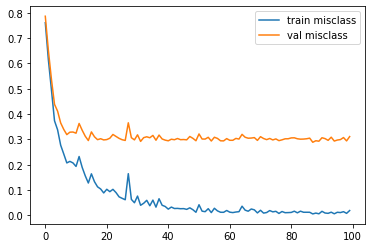

In [ ]:
plt.plot(range(EPOCHS), 1 - np.array(training_record1["train_acc"]), label="train misclass")
plt.plot(range(EPOCHS), 1 - np.array(training_record1["test_acc"]), label="val misclass")
plt.legend()
plt.show()

In [ ]:
print(get_loss_acc(nn1, train_loader, nn.CrossEntropyLoss()))
print(get_loss_acc(nn1, val_loader, nn.CrossEntropyLoss()))
print(get_loss_acc(nn1, test_loader, nn.CrossEntropyLoss()))

(0.1711320413615757, 0.9806)
(1.0551204552650453, 0.6888)
(0.9925422965288162, 0.7102)


### Model 2

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=(2,2))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=64, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, stride=1)
        self.fc1 = nn.Linear(6*13*32, 256)
        self.fc2 = nn.Linear(256, 19)

    def forward(self, x):
        x = x.view(-1, 1, 28, 56)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 6 * 13 * 32)
        x = self.fc2(F.relu(self.fc1(x)))

        return x

In [ ]:
EPOCHS = 50
cnn1 = CNN()
optimizer = torch.optim.SGD(cnn1.parameters(), lr=0.03)
criterion = nn.CrossEntropyLoss()
cnn1, training_record1, best_state1 = train7(cnn1, EPOCHS, train_loader, val_loader, optimizer, criterion)

Epoch 0/50  train_loss=2.7933733943171393 val_loss=2.803339538574219 train_acc=0.0835 val_acc=0.088
Epoch 1/50  train_loss=2.6407750498372526 val_loss=2.6514224824905397 train_acc=0.13495 val_acc=0.1328
Epoch 2/50  train_loss=2.366261902708596 val_loss=2.3929100217819212 train_acc=0.17595 val_acc=0.1668
Epoch 3/50  train_loss=2.1216938480401573 val_loss=2.1763342781066894 train_acc=0.2883 val_acc=0.2678
Epoch 4/50  train_loss=1.3997900063237443 val_loss=1.4816397640705108 train_acc=0.5389 val_acc=0.5178
Epoch 5/50  train_loss=1.0513272915785306 val_loss=1.1576276700496673 train_acc=0.6616 val_acc=0.6208
Epoch 6/50  train_loss=0.8332705910975179 val_loss=0.9512780210971832 train_acc=0.732 val_acc=0.689
Epoch 7/50  train_loss=0.6657328602795403 val_loss=0.8046500298976899 train_acc=0.78885 val_acc=0.74
Epoch 8/50  train_loss=0.7166924212877743 val_loss=0.8684240387678146 train_acc=0.76835 val_acc=0.7232
Epoch 9/50  train_loss=0.4126292593753376 val_loss=0.6043787180781365 train_acc=0.871

In [ ]:
cnn1.load_state_dict(best_state1)

<All keys matched successfully>

In [ ]:
summary(cnn1, (1, 28, 56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 56]             208
         MaxPool2d-2            [-1, 8, 14, 28]               0
            Conv2d-3           [-1, 64, 12, 26]           4,672
         MaxPool2d-4            [-1, 64, 6, 13]               0
            Conv2d-5            [-1, 32, 6, 13]           2,080
            Linear-6                  [-1, 256]         639,232
            Linear-7                   [-1, 19]           4,883
Total params: 651,075
Trainable params: 651,075
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.33
Params size (MB): 2.48
Estimated Total Size (MB): 2.82
----------------------------------------------------------------


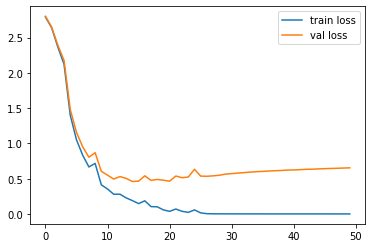

In [ ]:
plt.plot(range(EPOCHS), training_record1["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record1["test_loss"], label="val loss")
plt.legend()
plt.show()

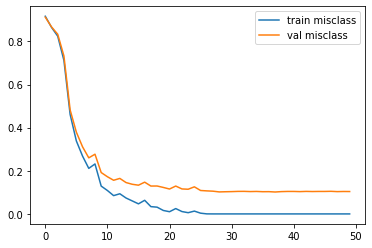

In [ ]:
plt.plot(range(EPOCHS), 1 - np.array(training_record1["train_acc"]), label="train misclass")
plt.plot(range(EPOCHS), 1 - np.array(training_record1["test_acc"]), label="val misclass")
plt.legend()
plt.show()

In [ ]:
print(get_loss_acc(cnn1, train_loader, nn.CrossEntropyLoss()))
print(get_loss_acc(cnn1, val_loader, nn.CrossEntropyLoss()))
print(get_loss_acc(cnn1, test_loader, nn.CrossEntropyLoss()))

(0.00033061225783636276, 1.0)
(0.6538210283771696, 0.8962)
(0.5886657707021222, 0.9102)


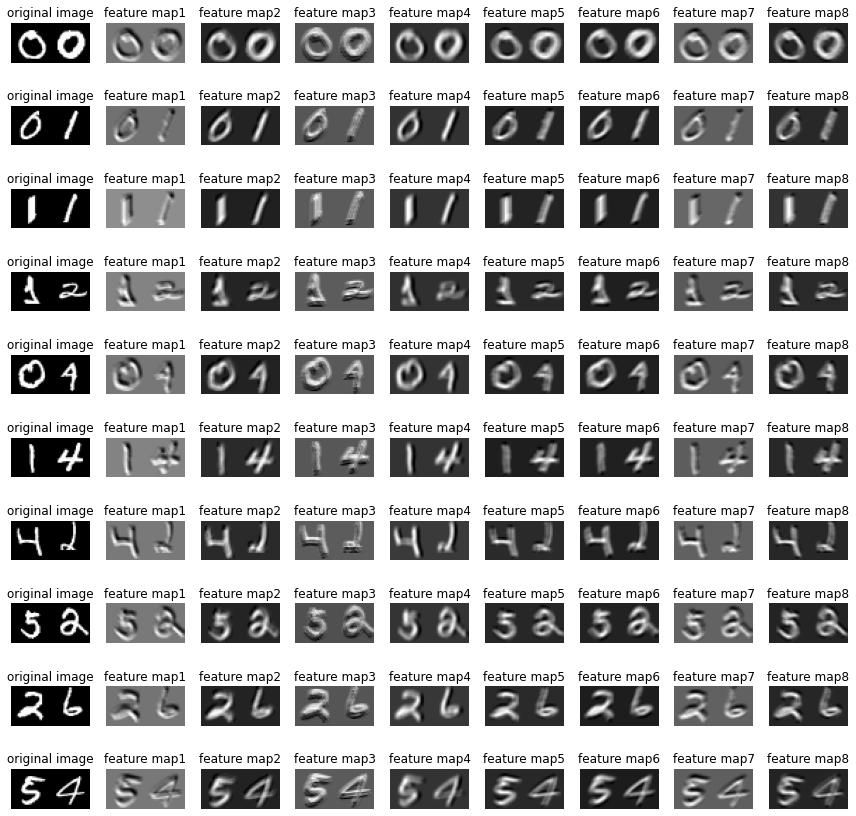

In [ ]:
fig, ax = plt.subplots(10, 9, figsize=(15,15))
for i in range(10):
    original_img = X_train_tensor[Y_train == i][0].cpu().detach().reshape(1,1,28,56)
    ax[i,0].imshow(original_img.squeeze().numpy(), cmap="gray")
    ax[i,0].set_title("original image")
    ax[i,0].axis("off")
    feature_maps = cnn1.cpu().conv1(original_img).detach().numpy().squeeze()
    for j in range(8):
        feature_map = feature_maps[j]
        ax[i, j+1].imshow(feature_map, cmap="gray")
        ax[i, j+1].set_title("feature map{}".format(j+1))
        ax[i, j+1].axis("off")

### Model 3

In [ ]:
class DoubleCNN(nn.Module):
    def __init__(self):
        super(DoubleCNN, self).__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.out = nn.Sequential(
            nn.Linear(6 * 6 * 64 * 2, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 19),
            nn.ReLU(inplace=True)
        )
  
  def forward(self, x):
    img = x.reshape(-1, 1, 28, 56)
    img1 = img[:, :, :, :28]
    img2 = img[:, :, :, 28:]
    output1 = self.CNN(img1).reshape(-1, 6*6*64)
    output2 = self.CNN(img2).reshape(-1, 6*6*64)
    output = torch.concat((output1, output2), dim=1)
    output = self.out(output)
    
    return output


class Prediction(nn.Module):
    def __init__(self):
        super(Prediction, self).__init__()
        self.CNN = CNN1.cpu()

    def forward(self, x):
        img = x.reshape(-1, 1, 28, 56)
        img1 = img[:, :, :, :28]
        img2 = img[:, :, :, 28:]
        pred1 = torch.argmax(self.CNN(img1), dim=1)
        pred2 = torch.argmax(self.CNN(img2), dim=1)
        pred = pred1 + pred2
        return pred 

In [ ]:
#train double CNN
epochs = 50
doublecnn = DoubleCNN()
optimizer = torch.optim.SGD(doublecnn.parameters(), lr=0.03, momentum=0.5)
criterion = nn.CrossEntropyLoss()
doublecnn, training_record, best_state = train7(doublecnn, epochs, train_loader, val_loader, optimizer, criterion)

Epoch 0/50  train_loss=2.762921387395158 val_loss=2.7718174180984496 train_acc=0.11985 val_acc=0.1054
Epoch 1/50  train_loss=2.249181287738081 val_loss=2.2934193897247312 train_acc=0.27165 val_acc=0.2548
Epoch 2/50  train_loss=1.0399427375854395 val_loss=1.1151686775684357 train_acc=0.6607 val_acc=0.632
Epoch 3/50  train_loss=0.542285427213096 val_loss=0.6652356241941452 train_acc=0.8229 val_acc=0.7848
Epoch 4/50  train_loss=0.3091966983038016 val_loss=0.4457338398396969 train_acc=0.90855 val_acc=0.8618
Epoch 5/50  train_loss=0.2475860710389698 val_loss=0.4314672233760357 train_acc=0.92195 val_acc=0.863
Epoch 6/50  train_loss=0.1670300597176194 val_loss=0.38451487917453053 train_acc=0.94745 val_acc=0.8818
Epoch 7/50  train_loss=0.10121375484207568 val_loss=0.34678949750959875 train_acc=0.97135 val_acc=0.8936
Epoch 8/50  train_loss=0.06448036598297543 val_loss=0.33156550873816015 train_acc=0.98465 val_acc=0.901
Epoch 9/50  train_loss=0.04907802785612857 val_loss=0.35448782783932986 trai

In [ ]:
doublecnn.load_state_dict(best_state)

<All keys matched successfully>

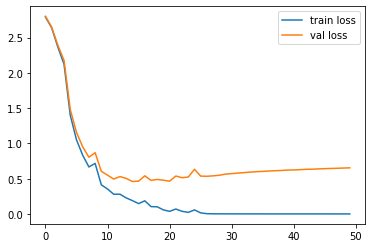

In [ ]:
plt.plot(range(EPOCHS), training_record1["train_loss"], label="train loss")
plt.plot(range(EPOCHS), training_record1["test_loss"], label="val loss")
plt.legend()
plt.show()

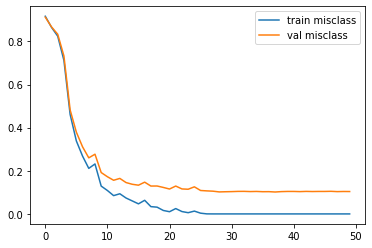

In [ ]:
plt.plot(range(EPOCHS), 1 - np.array(training_record1["train_acc"]), label="train misclass")
plt.plot(range(EPOCHS), 1 - np.array(training_record1["test_acc"]), label="val misclass")
plt.legend()
plt.show()

In [ ]:
print(get_loss_acc(doublecnn, train_loader, nn.CrossEntropyLoss()))
print(get_loss_acc(doublecnn, val_loader, nn.CrossEntropyLoss()))
print(get_loss_acc(doublecnn, test_loader, nn.CrossEntropyLoss()))

(0.00020936943718307346, 1.0)
(0.4579465706315823, 0.9142)
(0.4030925147113012, 0.9228)


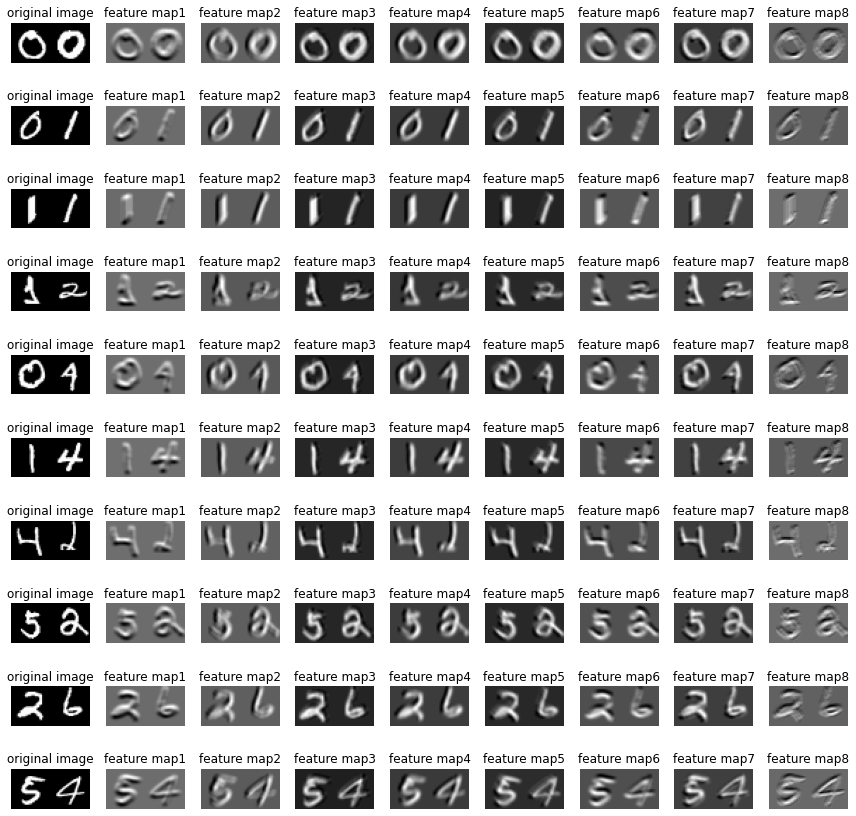

In [ ]:
fig, ax = plt.subplots(10, 9, figsize=(15,15))
for i in range(10):
    original_img = X_train_tensor[Y_train == i][0].cpu().detach().reshape(1,1,28,56)
    ax[i,0].imshow(original_img.squeeze().numpy(), cmap="gray")
    ax[i,0].set_title("original image")
    ax[i,0].axis("off")
    feature_map1 = doublecnn.cpu().CNN[0](original_img[:,:,:,:28]).detach().numpy().squeeze()
    feature_map2 = doublecnn.cpu().CNN[0](original_img[:,:,:,28:]).detach().numpy().squeeze()
    for j in range(8):
        feature_map = np.concatenate((feature_map1[j], feature_map2[j]), axis=1)
        ax[i, j+1].imshow(feature_map, cmap="gray")
        ax[i, j+1].set_title("feature map{}".format(j+1))
        ax[i, j+1].axis("off")

### Model 4

In [ ]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 3 * 3, 400),
            nn.ReLU(inplace=True),
            nn.Linear(400, 128 * 3 * 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.reshape(-1, 1, 28, 56)
        img1 = x[:,:,:,:28]
        img2 = x[:,:,:,28:]

        output1 = self.encoder(img1)
        output1 = output1.reshape(-1, 128 * 3 * 3)
        output1 = self.fc(output1)
        output1 = output1.reshape(-1, 128, 3, 3)
        output1 = self.decoder(output1)

        output2 = self.encoder(img2)
        output2 = output2.reshape(-1, 128 * 3 * 3)
        output2 = self.fc(output2)
        output2 = output2.reshape(-1, 128, 3, 3)
        output2 = self.decoder(output2)

        output = torch.concat((output1, output2), dim=3)
        output = output.squeeze()
        return output

In [ ]:
def train_ae(model, epochs, trainloader, testloader, optimizer, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    training_record = {
        "train_loss":[]
    }
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        num_batches = 0
        for X_batch, _ in trainloader:

            X_batch = X_batch.to(device)
            num_batches += 1
            #forward
            outputs = model(X_batch)

            loss = criterion(outputs, X_batch)
            #backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
            
        print("Epoch {}/{}  train_loss={}".format(
        epoch, epochs, train_loss / num_batches))


        
    return model

In [ ]:
#train autoencoder
epochs = 40
convae1 = ConvAE()
optimizer = torch.optim.Adam(convae1.parameters(), lr=0.003)
criterion = nn.BCELoss()
convae1 = train_ae(convae1, epochs, train_loader, val_loader, optimizer, criterion).cpu()

Epoch 0/40  train_loss=0.14829121134913387
Epoch 1/40  train_loss=0.08422008330543963
Epoch 2/40  train_loss=0.07687734862486013
Epoch 3/40  train_loss=0.07388940698708209
Epoch 4/40  train_loss=0.07209000855493851
Epoch 5/40  train_loss=0.07094811345822515
Epoch 6/40  train_loss=0.07003987806673628
Epoch 7/40  train_loss=0.06946585743952864
Epoch 8/40  train_loss=0.06878312146320892
Epoch 9/40  train_loss=0.06844633574874256
Epoch 10/40  train_loss=0.06809639542723617
Epoch 11/40  train_loss=0.06785904109097136
Epoch 12/40  train_loss=0.06759038715126416
Epoch 13/40  train_loss=0.0673174802035379
Epoch 14/40  train_loss=0.06716190999784409
Epoch 15/40  train_loss=0.06694906350141897
Epoch 16/40  train_loss=0.06673933071688341
Epoch 17/40  train_loss=0.06654500397154317
Epoch 18/40  train_loss=0.06640519817083027
Epoch 19/40  train_loss=0.06634538599286978
Epoch 20/40  train_loss=0.06616424776304264
Epoch 21/40  train_loss=0.06599484121028226
Epoch 22/40  train_loss=0.06586494881171769

In [ ]:
summary(convae1.cuda(), (1, 28, 56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
         MaxPool2d-2           [-1, 32, 14, 14]               0
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
         MaxPool2d-5             [-1, 64, 7, 7]               0
              ReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 3, 3]          73,856
            Linear-8                  [-1, 400]         461,200
              ReLU-9                  [-1, 400]               0
           Linear-10                 [-1, 1152]         461,952
  ConvTranspose2d-11             [-1, 64, 7, 7]          73,792
             ReLU-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13           [-1, 32, 14, 14]           8,224
             ReLU-14           [-1, 32,

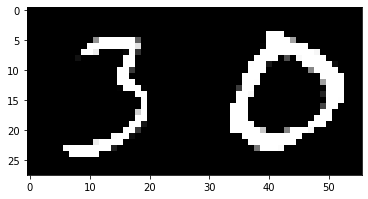

In [ ]:
show_2_img(convae1(X_test_tensor[1].reshape(1,1,28,56)).detach().numpy())

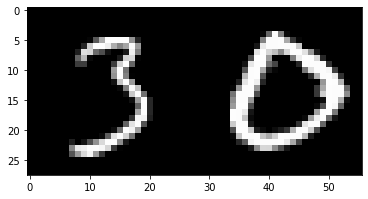

In [ ]:
show_2_img(X_test_tensor[1])

In [ ]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = None
        self.fc = None
    def forward(self, x):
        img = x.reshape(-1, 1, 28, 28)
        output = self.encoder(img)
        output = output.reshape(-1, 128 * 3 * 3)
        output = self.fc(output)
        return output

trained_ae = AE()
trained_ae.encoder = convae1.encoder
# for params in trained_ae.parameters():
#   params.require_grads = False
trained_ae.fc = nn.Sequential(
    nn.Linear(128 * 3 * 3, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 10)
)

In [ ]:
#train classifier
EPOCHS = 50
optimizer = torch.optim.SGD(trained_ae.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
trained_ae, training_record, best_state = train(trained_ae, EPOCHS, trainloader, testloader, optimizer, criterion)


Epoch 0/50  train_loss=0.028419384988881687 test_loss=0.033309511155057404 train_acc=0.991 test_acc=0.9889
Epoch 1/50  train_loss=0.06045557170707821 test_loss=0.06980294760807737 train_acc=0.98055 test_acc=0.9782
Epoch 2/50  train_loss=0.023896088106924472 test_loss=0.040146530728682135 train_acc=0.9923833333333333 test_acc=0.9875
Epoch 3/50  train_loss=0.009116940098705884 test_loss=0.02632863177736067 train_acc=0.9970333333333333 test_acc=0.9924
Epoch 4/50  train_loss=0.012469270789509294 test_loss=0.03501261089454943 train_acc=0.99605 test_acc=0.9907
Epoch 5/50  train_loss=0.0033996642140982367 test_loss=0.029066289706660562 train_acc=0.9992166666666666 test_acc=0.9917
Epoch 6/50  train_loss=0.006235034369126061 test_loss=0.03579206630783079 train_acc=0.9979166666666667 test_acc=0.9896
Epoch 7/50  train_loss=0.0016733107078863137 test_loss=0.02895858472766585 train_acc=0.9996833333333334 test_acc=0.9918
Epoch 8/50  train_loss=0.0013536805142557724 test_loss=0.027147158885507307 tra

In [ ]:
trained_ae.load_state_dict(best_state)

<All keys matched successfully>

In [ ]:
summary(trained_ae, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
         MaxPool2d-2           [-1, 32, 14, 14]               0
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
         MaxPool2d-5             [-1, 64, 7, 7]               0
              ReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 3, 3]          73,856
            Linear-8                  [-1, 256]         295,168
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 390,922
Trainable params: 390,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 1.49
Estimated T

In [ ]:
print(get_loss_acc(trained_ae, trainloader, nn.CrossEntropyLoss()))
print(get_loss_acc(trained_ae, testloader, nn.CrossEntropyLoss()))

(2.116149073006479e-05, 1.0)
(0.03662064589829899, 0.9925)


In [ ]:
class Prediction(nn.Module):
    def __init__(self):
        super(Prediction, self).__init__()
        self.ae = trained_ae.cpu()

    def forward(self, x):
        img = x.reshape(-1, 1, 28, 56)
        img1 = img[:, :, :, :28]
        img2 = img[:, :, :, 28:]
        pred1 = torch.argmax(self.ae(img1), dim=1)
        pred2 = torch.argmax(self.ae(img2), dim=1)
        pred = pred1 + pred2
        return pred 
predictor = Prediction()
correct = 0
total = 0
for X_batch, Y_batch in test_loader:
    pred = predictor(X_batch)
    correct += torch.sum(pred == Y_batch).cpu().numpy()
    total += len(Y_batch)

print(correct / total)

0.985
